# Sample Terason Analysis

In [3]:
%load_ext autoreload
%autoreload 2
import os
from pathlib import Path

print(Path().cwd())

/Users/davidspector/Home/Stanford/QuantUS Projects/PyQuantUS/CLI-Demos


In [4]:
os.chdir(Path().cwd().parent)

In [5]:
print(Path().cwd())

/Users/davidspector/Home/Stanford/QuantUS Projects/PyQuantUS


## Select Image & Phantom and Parse

In [6]:
from pyquantus.parse.terason import terasonRfParser

In [7]:
# Inputs
imagePath = '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Terason RF/im.mat'
phantomPath = '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Terason RF/phantom.mat'

In [8]:
imgDataStruct, imgInfoStruct, refDataStruct, refInfoStuct = terasonRfParser(imagePath, phantomPath)

## ROI Selection (from GUI)

In [9]:
import pickle

pkl_name = '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Terason RF/roi.pkl'

with open(pkl_name, "rb") as f:
    roi_info = pickle.load(f)

In [10]:
assert roi_info["Image Name"] == Path(imagePath).name
assert roi_info["Phantom Name"] == Path(phantomPath).name

In [11]:
splineX = roi_info["Spline X"]
splineY = roi_info["Spline Y"]

## Analysis Config (from GUI)

In [12]:
from pyquantus.utc import AnalysisConfig

config = AnalysisConfig()

config.transducerFreqBand = [3000000, 15000000] # [min, max] (Hz)
config.analysisFreqBand = [5000000.0, 13000000.0] # [lower, upper] (Hz)
config.samplingFrequency = 44090000 # Hz
config.axWinSize = 0.71 # axial length per window (mm)
config.latWinSize = 0.71 # lateral length per window (mm)
config.windowThresh = 0.95 # % of window area required to be considered in ROI
config.axialOverlap = 0.5 # % of window overlap in axial direction
config.lateralOverlap = 0.5 # % of window overlap in lateral direction
config.centerFrequency = 9000000 # Hz

## UTC Analysis

In [13]:
from pyquantus.utc import UtcAnalysis, UltrasoundImage

In [14]:
ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfoStruct.axialRes
ultrasoundImage.lateralResRf = imgInfoStruct.lateralRes
ultrasoundImage.bmode = imgDataStruct.bMode
ultrasoundImage.phantomRf = refDataStruct.rf
ultrasoundImage.rf = imgDataStruct.rf

In [15]:
utcAnalysis = UtcAnalysis()
utcAnalysis.ultrasoundImage = ultrasoundImage
utcAnalysis.config = config
utcAnalysis.splineX = splineX
utcAnalysis.splineY = splineY

In [16]:
utcAnalysis.refAttenuation = 0.5 # placeholder for attenuation coefficient at center freq (dB/cm/MHz)
utcAnalysis.refBackScatterCoef = 10e-3 # placeholder for backscatter coefficient at center freq (cm^-1 sr^-1)

In [17]:
utcAnalysis.generateRoiWindows()
utcAnalysis.computeUtcWindows();

100%|██████████| 277/277 [00:02<00:00, 102.37it/s]


In [20]:
import numpy as np

mbfArr = [window.results.mbf for window in utcAnalysis.roiWindows]
ssArr = [window.results.ss for window in utcAnalysis.roiWindows]
siArr = [window.results.si for window in utcAnalysis.roiWindows]
attArr = [window.results.attCoef for window in utcAnalysis.roiWindows]
bscArr = [window.results.bsc for window in utcAnalysis.roiWindows]
uNakagamiArr = [window.results.uNakagami for window in utcAnalysis.roiWindows]

print("Average Midband Fit:", np.mean(mbfArr), "dB")
print("Average Spectral Slope:", np.mean(ssArr), "dB/MHz")
print("Average Spectral Intercept:", np.mean(siArr), "dB")
print("Average Attenuation Coefficient:", np.mean(attArr), "dB/cm/MHz")
print("Average Backscatter Coefficient:", np.mean(bscArr), "1/cm-sr")
print("Average Nakagami Parameter:", np.mean(uNakagamiArr))
print("w Nakagami Parameter:", utcAnalysis.nakagamiParams[0])
print("u Nakagami Parameter:", utcAnalysis.nakagamiParams[1])
# print("Effective Scatterer Diameter:", utcAnalysis.effectiveScattererDiameter, "µm") 
# print("Effective Scatterer Concentration:", utcAnalysis.effectiveScattererConcentration, "dB/mm^3")

Average Midband Fit: 20.835994146288222 dB
Average Spectral Slope: 0.2406503836973601 dB/MHz
Average Spectral Intercept: 18.670155970536033 dB
Average Attenuation Coefficient: 0.9634102524445352 dB/cm/MHz
Average Backscatter Coefficient: 0.3591985822808045 1/cm-sr
Average Nakagami Parameter: 21.140939766290188
w Nakagami Parameter: 4361.7501057958225
u Nakagami Parameter: 0.7477095870062037


# Visualizations

In [21]:
import matplotlib.pyplot as plt
from pyquantus.utc import UtcData

In [22]:
utcData = UtcData()
utcData.utcAnalysis = utcAnalysis

In [23]:
utcData.convertImagesToRGB()

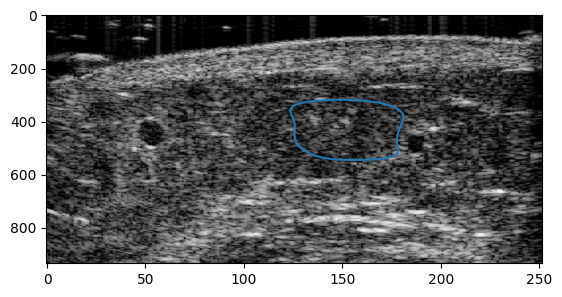

In [24]:
quotient = imgInfoStruct.depth / imgInfoStruct.width
plt.imshow(utcData.finalBmode, aspect=quotient*(utcData.finalBmode.shape[1]/utcData.finalBmode.shape[0]))
plt.plot(utcData.splineX, utcData.splineY)

In [25]:
utcData.drawCmaps()

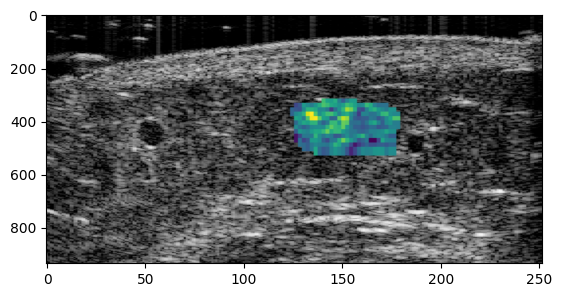

In [26]:
plt.imshow(utcData.mbfIm, aspect=quotient*(utcData.finalBmode.shape[1]/utcData.finalBmode.shape[0]))

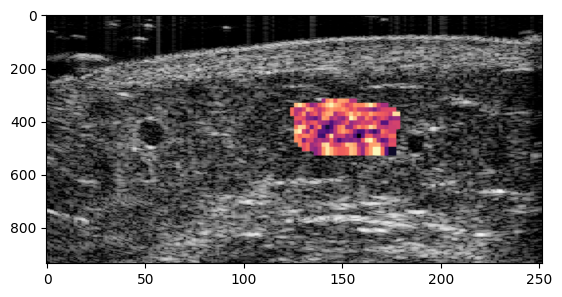

In [27]:
plt.imshow(utcData.ssIm, aspect=quotient*(utcData.finalBmode.shape[1]/utcData.finalBmode.shape[0]))

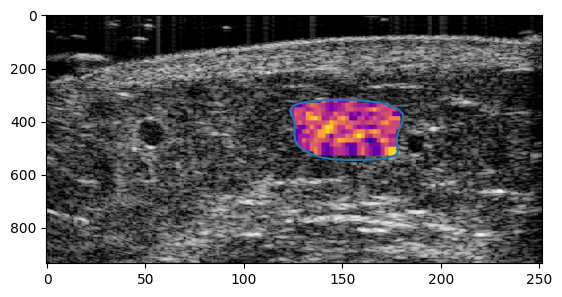

In [28]:
plt.imshow(utcData.siIm, aspect=quotient*(utcData.finalBmode.shape[1]/utcData.finalBmode.shape[0]))
plt.plot(utcData.splineX, utcData.splineY)

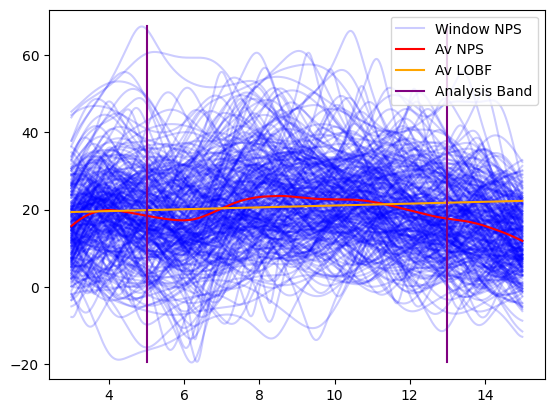

In [29]:
utcData.plotPsData()